In [2]:
include("../source/spin-1_XY_ED.jl")

odlro_matrix (generic function with 1 method)

In [3]:
N = 8
J1,J3,D,h = 1.0,0.1,0.1,1.0
boundary = "OBC"
use_sparse = false
basis_list = gen_basis_full_1D(N)
neel_state = nematic_neel_1D(N,basis_list)

time_list::Vector{Float64} = Vector{Float64}((LinRange(0,30,600)))
n_t = length(time_list)
t_step = time_list[2]-time_list[1];

In [4]:
@time begin
    J2_list::Vector{Float64} = Vector{Float64}((LinRange(0.01,0.2,30)))
    J2_neel_evolved_state_list = Vector{Vector{Vector{ComplexF64}}}(undef,length(J2_list))
    
    for (pos,J2) in enumerate(J2_list)
        top_folder = joinpath("D:\\IACS_Project\\spin-1_XY\\data\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\OBC")
        neel_evolved_file = joinpath(top_folder,"neel_t_evolved_state",
        "evolved_state_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_J2=$(round(J2,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6))_tstep=$(round(t_step,digits=6)).jld2")
        neel_evolved_state_list = JLD2.load(neel_evolved_file)["evolved_state_list"]
        J2_neel_evolved_state_list[pos] = neel_evolved_state_list
    end    
end;

 21.807123 seconds (5.68 M allocations: 1.964 GiB, 9.07% gc time, 9.73% compilation time: 37% of which was recompilation)


In [5]:
r = 1
basis_new = similar(basis_list[1])

@time begin
    S_plus_sq_matrix,nematic_matrix_size = S_plus_sq(r,basis_list,basis_new)
    S_minus_sq_matrix,nematic_matrix_size = S_minus_sq(r,basis_list,basis_new)
end;

  0.454097 seconds (16.22 k allocations: 2.472 MiB, 22.88% compilation time)


In [6]:
outvect::Vector{ComplexF64} = Vector{ComplexF64}(undef,nematic_matrix_size)

@time begin
    J2_neel_director_list::Vector{Vector{Float64}} = Vector{Vector{Float64}}(undef,length(J2_list))
    
    for (pos,J2) in enumerate(J2_list)
        neel_plus_director_list::Vector{ComplexF64} = Vector{ComplexF64}(undef,n_t)
        neel_minus_director_list::Vector{ComplexF64} = Vector{ComplexF64}(undef,n_t)
        neel_evolved_state_list = J2_neel_evolved_state_list[pos]
        for i in 1:n_t
            neel_t_evolved_state = neel_evolved_state_list[i]
            mul!(outvect,S_plus_sq_matrix,neel_t_evolved_state)
            neel_plus_director_list[i] = real(dot(neel_t_evolved_state,outvect))
            mul!(outvect,S_minus_sq_matrix,neel_t_evolved_state)
            neel_minus_director_list[i] = real(dot(neel_t_evolved_state,outvect))
        end
        average_nematic_neel_director_list = [(abs(imag(x))<1e-6 ? real(x) : x) 
                                      for x in (neel_plus_director_list+neel_minus_director_list)/2]
        J2_neel_director_list[pos] = average_nematic_neel_director_list
    end
end;

 11.956404 seconds (2.62 M allocations: 176.672 MiB, 12.66% compilation time)


In [8]:
clip = 600
time_data = h*time_list[1:clip] 
model(t,p) = p[1]*exp.(-t./p[2]).*cos.(p[3].*t)

n = length(J2_list)
y_data_list::Vector{Vector{Float64}} = Vector{Vector{Float64}}(undef,n)
fitted_data_list::Vector{Vector{Float64}} = Vector{Vector{Float64}}(undef,n)
fitted_timescale_list::Vector{Float64} = Vector{Float64}(undef,n)

@time begin
    for i in 1:n
        y_data = J2_neel_director_list[i][1:clip]
        y_data_list[i] = y_data
        p0 = [maximum(y_data),1.0,1.0] # Initial parameter guess: [A,b,omega]
        fit = curve_fit(model,time_data,y_data,p0)
        A_fit, b_fit, w_fit = fit.param
        fitted_data = model(time_data,fit.param)
        fitted_data_list[i] = fitted_data
        fitted_timescale_list[i] = b_fit
    end
end;

  5.580260 seconds (5.08 M allocations: 447.657 MiB, 14.27% gc time, 96.05% compilation time)


### Envelope Fitting Plot

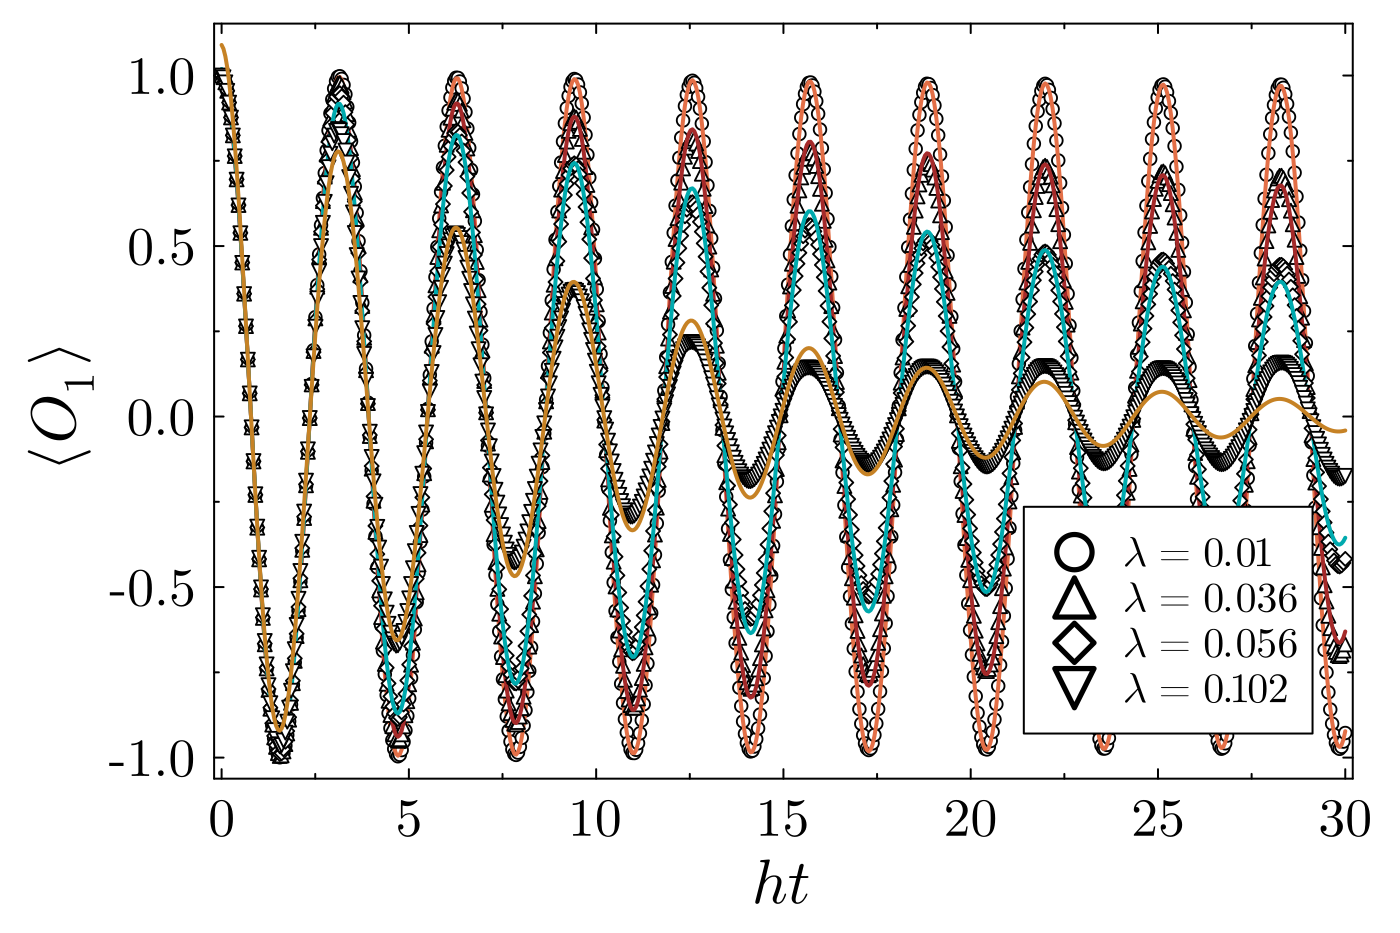

"D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=8\\sec_nbr_perturbed\\OBC\\observable_decay_time\\Nematic_directors_fit_r=1_J1=1.0_J3=0.1_D=0.1_h=1.0.png"

In [25]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)
default(fontfamily="Computer Modern")

n1,n2,n3,n4 = 1,5,8,15
J2_1 = round(J2_list[n1],digits=3)
J2_2 = round(J2_list[n2],digits=3)
J2_3 = round(J2_list[n3],digits=3)
J2_4 = round(J2_list[n4],digits=3)

p = scatter(time_data,y_data_list[n1],marker=:circle,markercolor=:white,ms=3.5,markerstrokewidth=1,
            label="\$\\lambda=$(J2_1)\$",size=plot_size,dpi=200)
plot!(time_data,fitted_data_list[n1],lw=2,label=false,ls=:solid)

scatter!(time_data,y_data_list[n2],marker=:utriangle,markercolor=:white,ms=3.5,markerstrokewidth=1,
         label="\$\\lambda=$(J2_2)\$")
plot!(time_data,fitted_data_list[n2],lw=2,c=:brown,label=false,ls=:solid)

scatter!(time_data,y_data_list[n3],marker=:diamond,markercolor=:white,ms=3.5,markerstrokewidth=1,
         label="\$\\lambda=$(J2_3)\$")
plot!(time_data,fitted_data_list[n3],lw=2,label=false,ls=:solid)

scatter!(time_data,y_data_list[n4],marker=:dtriangle,markercolor=:white,ms=3.5,markerstrokewidth=1,
          label="\$\\lambda=$(J2_4)\$")
plot!(time_data,fitted_data_list[n4],lw=2,label=false,ls=:solid)

plot!(left_margin=5mm,right_margin=4mm,top_margin=1mm,bottom_margin=4mm)
plot!(framestyle=:box)
plot!(legend=false)
plot!(legend_position=(0.8,0.3),legendfontsize=14,legend_background_color=:white,
       legend_foreground_color=:black,legend_columns=1)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$ht\$",guidefontsize=21)
ylabel!("\$\\langle O_{$r}\\rangle\$",guidefontsize=21)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0,5,30
y1,y_step,y2 = -1,0.5,5
xticks = (x1:x_step:x2,[@sprintf("%.0f",x) for x in x1:x_step:x2])
yticks = (y1:y_step:y2,[@sprintf("%.1f",y) for y in y1:y_step:y2])
xminor_ticks = 2 
yminor_ticks = 2
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=17,tick_direction=:in)
plot!(xlims=(x1-0.2,x2+0.2))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\observable_decay_time"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Nematic_directors_fit_r=$(r)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

### Decay Time ($\tau$) vs $J_2$

In [9]:
sq_J2_list = (J2_list).^2
inv_timescale = 1.0./(fitted_timescale_list)
lin_params = fit(sq_J2_list,inv_timescale,1)   # Linear fit
fitted_timescale = lin_params.(sq_J2_list);

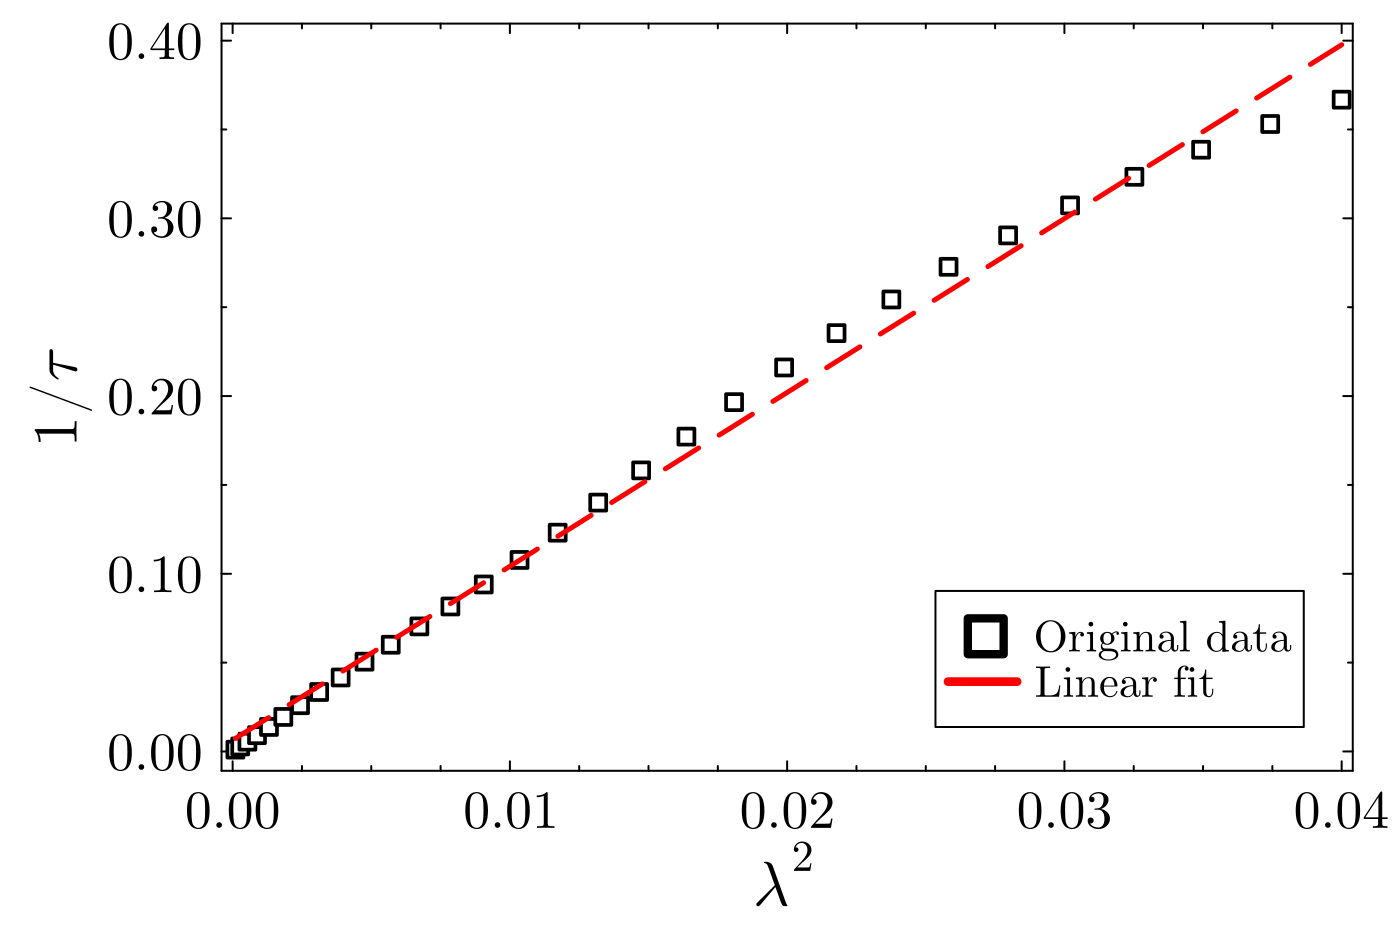

"D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=8\\sec_nbr_perturbed\\OBC\\observable_decay_time\\Timescale_r=1_J1=1.0_J3=0.1_D=0.1_h=1.0.png"

In [24]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)
default(fontfamily="Computer Modern")

p = scatter(sq_J2_list,inv_timescale,marker=:square,markercolor=:white,ms=4,markerstrokewidth=2,
              label="Original data",size=plot_size,dpi=200)
plot!(sq_J2_list,fitted_timescale,lw=2.5,c=:red,ls=:dash,label="Linear fit")

plot!(left_margin=5mm,right_margin=4mm,top_margin=1mm,bottom_margin=5mm)
plot!(framestyle=:box)
plot!(legend=false)
plot!(legend_position=(0.72,0.18),legendfontsize=14,legend_background_color=:white,legend_foreground_color=:black)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)

xlabel!("\$\\lambda^2\$",guidefontsize=21)
ylabel!("\$1/\\tau\$",guidefontsize=21)

x1,x_step,x2 = 0,0.01,0.04
y1,y_step,y2 = 0,0.1,0.4
xticks = (x1:x_step:x2,[@sprintf("%.2f",x) for x in x1:x_step:x2])
yticks = (y1:y_step:y2,[@sprintf("%.2f",y) for y in y1:y_step:y2])
xminor_ticks = 4 
yminor_ticks = 2
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=17,tick_direction=:in)
plot!(xlims=(x1-0.0004,x2+0.0004))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\observable_decay_time"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Timescale_r=$(r)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)